In [128]:
import numpy as np
import ase
from ase.io import read, write
from ase.calculators.lj import LennardJones
from ase.visualize import view

import matplotlib.pyplot as plt
from dscribe.descriptors import SOAP

# Generate the structures

In [155]:
n_samples = 200
r = np.linspace(2.5, 5.0, n_samples)
#cell = np.eye(3)*15.0 # Unit cell is simple cubic with L=25.0 Å
#pbc = [0, 0, 0]

traj = []
for i, d in enumerate(r):
    atoms = ase.Atoms('HeHe', positions = [[-0.5 * d, 0, 0], [0.5 * d, 0, 0]])
#    atoms.set_cell(cell)
#    atoms.set_pbc(pbc)
#    atoms.center()
    traj.append(atoms)


In [156]:
!rm database.xyz

for atoms in traj:
    atoms.write('database.xyz', append=True)
    
!cat database.xyz

2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.25000000       0.00000000       0.00000000
He       1.25000000       0.00000000       0.00000000
2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.25628141       0.00000000       0.00000000
He       1.25628141       0.00000000       0.00000000
2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.26256281       0.00000000       0.00000000
He       1.26256281       0.00000000       0.00000000
2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.26884422       0.00000000       0.00000000
He       1.26884422       0.00000000       0.00000000
2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.27512563       0.00000000       0.00000000
He       1.27512563       0.00000000       0.00000000
2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.28140704       0.00000000       0.00000000
He       1.28140704       0.00000000       0.00000000
2
Properties=species:S:1:pos:R:3 pbc="F F F"
He      -1.28768844       0.00000000 

In [131]:
view(traj)

# Calculate the energy and forces

In [157]:
all_energy = []
all_forces = []
for atoms in traj:
    atoms.set_calculator(LennardJones(epsilon=1.0, sigma=2.9))
    energy = atoms.get_total_energy()
    all_energy.append(energy)
    forces = atoms.get_forces()
    all_forces.append(forces)

In [158]:
!rm database.xyz

for atoms in traj:
    atoms.write('database.xyz', append=True)
    
!cat database.xyz

2
Properties=species:S:1:pos:R:3:forces:R:3:energies:R:1 energy=14.004002317805558 free_energy=14.004002317805558 pbc="F F F"
He      -1.25000000       0.00000000       0.00000000     -90.58231450       0.00000000       0.00000000       7.00200116
He       1.25000000       0.00000000       0.00000000      90.58231450       0.00000000       0.00000000       7.00200116
2
Properties=species:S:1:pos:R:3:forces:R:3:energies:R:1 energy=12.906625167710272 free_energy=12.906625167710272 pbc="F F F"
He      -1.25628141       0.00000000       0.00000000     -84.19882514       0.00000000       0.00000000       6.45331258
He       1.25628141       0.00000000       0.00000000      84.19882514       0.00000000       0.00000000       6.45331258
2
Properties=species:S:1:pos:R:3:forces:R:3:energies:R:1 energy=11.886551170285909 free_energy=11.886551170285909 pbc="F F F"
He      -1.26256281       0.00000000       0.00000000     -78.26981380       0.00000000       0.00000000       5.94327559
He       1.2

# Assign descriptor for each atomic structure

In [159]:
# Setting up the SOAP descriptor

soap = SOAP(
    species=["He"],
    periodic=False,
    r_cut=5.0,
    sigma=0.5,
    n_max=3,
    l_max=0,
)
    

In [173]:
#derivatives, descriptors = soap.derivatives(traj, centers=[[0]]*len(traj), method="analytical")
derivatives, descriptors = soap.derivatives(traj, centers=[[[0, 0, 0]]] * len(r), method="analytical")

# Organize all the ML requirements

In [174]:
np.save("r.npy", r)
np.save("E.npy", all_energy)
np.save("D.npy", descriptors)
np.save("dD_dr.npy", derivatives)
np.save("F.npy", all_forces)

# Construct machine learning potential

In [175]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
torch.manual_seed(7)

## Load dataset

In [176]:
D_numpy = np.load("D.npy")[:, 0, :]  # We only have one SOAP center
n_samples, n_features = D_numpy.shape
E_numpy = np.array([np.load("E.npy")]).T
F_numpy = np.load("F.npy")
dD_dr_numpy = np.load("dD_dr.npy")[:, 0, :, :, :]  # We only have one SOAP center
r_numpy = np.load("r.npy")

## Select data

In [187]:
# Select equally spaced points for training
n_train = 50
idx = np.linspace(0, len(r_numpy) - 1, n_train).astype(int)
D_train_full = D_numpy[idx]
E_train_full = E_numpy[idx]
F_train_full = F_numpy[idx]
r_train_full = r_numpy[idx]
dD_dr_train_full = dD_dr_numpy[idx]

## Standardize the data

In [188]:
# Standardize input for improved learning. Fit is done only on training data,
# scaling is applied to both descriptors and their derivatives on training and
# test sets.
scaler = StandardScaler().fit(D_train_full)
D_train_full = scaler.transform(D_train_full)
D_whole = scaler.transform(D_numpy)
dD_dr_whole = dD_dr_numpy / scaler.scale_[None, None, None, :]
dD_dr_train_full = dD_dr_train_full / scaler.scale_[None, None, None, :]

# Calculate the variance of energy and force values for the training set. These
# are used to balance their contribution to the MSE loss
var_energy_train = E_train_full.var()
var_force_train = F_train_full.var()

## Define early stopping criterion

In [189]:
# Subselect 20% of validation points for early stopping.
D_train, D_valid, E_train, E_valid, F_train, F_valid, dD_dr_train, dD_dr_valid = train_test_split(
    D_train_full,
    E_train_full,
    F_train_full,
    dD_dr_train_full,
    test_size=0.2,
    random_state=7,
)

## Create tensors for pytorch

In [190]:
# Create tensors for pytorch
D_whole = torch.Tensor(D_whole)
D_train = torch.Tensor(D_train)
D_valid = torch.Tensor(D_valid)
E_train = torch.Tensor(E_train)
E_valid = torch.Tensor(E_valid)
F_train = torch.Tensor(F_train)
F_valid = torch.Tensor(F_valid)
dD_dr_train = torch.Tensor(dD_dr_train)
dD_dr_valid = torch.Tensor(dD_dr_valid)

## Define model and loss function

In [191]:
class FFNet(torch.nn.Module):
    """A simple feed-forward network with one hidden layer, randomly
    initialized weights, sigmoid activation and a linear output layer.
    """
    def __init__(self, n_features, n_hidden, n_out):
        super(FFNet, self).__init__()
        self.linear1 = torch.nn.Linear(n_features, n_hidden)
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=1.0)
        self.sigmoid = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(n_hidden, n_out)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=1.0)

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)

        return x


def energy_force_loss(E_pred, E_train, F_pred, F_train):
    """Custom loss function that targets both energies and forces.
    """
    energy_loss = torch.mean((E_pred - E_train)**2) / var_energy_train
    force_loss = torch.mean((F_pred - F_train)**2) / var_force_train
    return energy_loss + force_loss


# Initialize model
model = FFNet(n_features, n_hidden=5, n_out=1)

# The Adam optimizer is used for training the model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

## Perform training

In [192]:
# Train!
n_max_epochs = 5000
batch_size = 2
patience = 20
i_worse = 0
old_valid_loss = float("Inf")
best_valid_loss = float("Inf")

# We explicitly require that the gradients should be calculated for the input
# variables. PyTorch will not do this by default as it is typically not needed.
D_valid.requires_grad = True

# Epochs
for i_epoch in range(n_max_epochs):

    # Batches
    permutation = torch.randperm(D_train.size()[0])
    for i in range(0, D_train.size()[0], batch_size):

        indices = permutation[i:i + batch_size]
        D_train_batch, E_train_batch = D_train[indices], E_train[indices]
        D_train_batch.requires_grad = True
        F_train_batch, dD_dr_train_batch = F_train[indices], dD_dr_train[indices]

        # Forward pass: Predict energies from the descriptor input
        E_train_pred_batch = model(D_train_batch)

        # Get derivatives of model output with respect to input variables. The
        # torch.autograd.grad-function can be used for this, as it returns the
        # gradients of the input with respect to outputs. It is very important
        # to set the create_graph=True in this case. Without it the derivatives
        # of the NN parameters with respect to the loss from the force error
        # will not be populated (=the force error will not affect the
        # training), but the model will still run fine without errors.
        df_dD_train_batch = torch.autograd.grad(
            outputs=E_train_pred_batch,
            inputs=D_train_batch,
            grad_outputs=torch.ones_like(E_train_pred_batch),
            create_graph=True,
        )[0]

        # Get derivatives of input variables (=descriptor) with respect to atom
        # positions = forces
        F_train_pred_batch = -torch.einsum('ijkl,il->ijk', dD_dr_train_batch, df_dD_train_batch)

        # Zero gradients, perform a backward pass, and update the weights.
        # D_train_batch.grad.data.zero_()
        optimizer.zero_grad()
        loss = energy_force_loss(E_train_pred_batch, E_train_batch, F_train_pred_batch, F_train_batch)
        loss.backward()
        optimizer.step()

    # Check early stopping criterion and save best model
    E_valid_pred = model(D_valid)
    df_dD_valid = torch.autograd.grad(
        outputs=E_valid_pred,
        inputs=D_valid,
        grad_outputs=torch.ones_like(E_valid_pred),
    )[0]
    F_valid_pred = -torch.einsum('ijkl,il->ijk', dD_dr_valid, df_dD_valid)
    valid_loss = energy_force_loss(E_valid_pred, E_valid, F_valid_pred, F_valid)
    if valid_loss < best_valid_loss:
        # print("Saving at epoch {}".format(i_epoch))
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
    if valid_loss >= old_valid_loss:
        i_worse += 1
    else:
        i_worse = 0
    if i_worse > patience:
        print("Early stopping at epoch {}".format(i_epoch))
        break
    old_valid_loss = valid_loss

    if i_epoch % 500 == 0:
        print("  Finished epoch: {} with loss: {}".format(i_epoch, loss.item()))

  Finished epoch: 0 with loss: 0.002480342984199524
  Finished epoch: 500 with loss: 0.0007293921080417931
  Finished epoch: 1000 with loss: 3.86358515243046e-05
  Finished epoch: 1500 with loss: 0.0009784563444554806
  Finished epoch: 2000 with loss: 4.558129876386374e-05
  Finished epoch: 2500 with loss: 7.434185681631789e-05
  Finished epoch: 3000 with loss: 0.0002604082983452827
  Finished epoch: 3500 with loss: 7.887231913628057e-05
  Finished epoch: 4000 with loss: 1.0439052857691422e-05
  Finished epoch: 4500 with loss: 0.00012252156739123166


In [193]:
# Way to tell pytorch that we are entering the evaluation phase
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Calculate energies and force for the entire range
E_whole = torch.Tensor(E_numpy)
F_whole = torch.Tensor(F_numpy)
dD_dr_whole = torch.Tensor(dD_dr_whole)
D_whole.requires_grad = True
E_whole_pred = model(D_whole)
df_dD_whole = torch.autograd.grad(
    outputs=E_whole_pred,
    inputs=D_whole,
    grad_outputs=torch.ones_like(E_whole_pred),
)[0]
F_whole_pred = -torch.einsum('ijkl,il->ijk', dD_dr_whole, df_dD_whole)
E_whole_pred = E_whole_pred.detach().numpy()
E_whole = E_whole.detach().numpy()

# Save results for later analysis
np.save("r_train_full.npy", r_train_full)
np.save("E_train_full.npy", E_train_full)
np.save("F_train_full.npy", F_train_full)
np.save("E_whole_pred.npy", E_whole_pred)
np.save("F_whole_pred.npy", F_whole_pred)

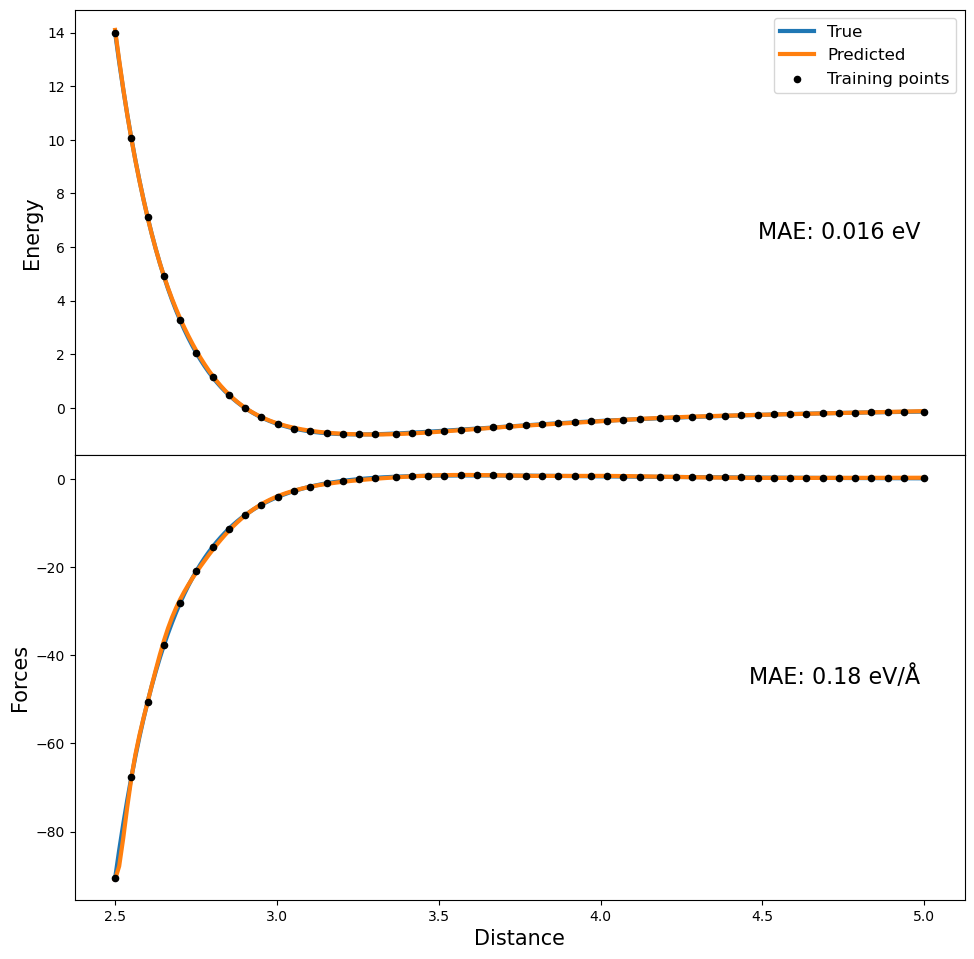

In [194]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load data as produded by the trained model
r_whole = np.load("r.npy")
r_train_full = np.load("r_train_full.npy")
order = np.argsort(r_whole)
E_whole = np.load("E.npy")
E_train_full = np.load("E_train_full.npy")
E_whole_pred = np.load("E_whole_pred.npy")
F_whole = np.load("F.npy")
F_train_full = np.load("F_train_full.npy")
F_whole_pred = np.load("F_whole_pred.npy")
F_x_whole_pred = F_whole_pred[order, 0, 0]
F_x_whole = F_whole[:, 0, 0][order]
F_x_train_full = F_train_full[:, 0, 0]

# Plot energies for the whole range
order = np.argsort(r_whole)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1.plot(r_whole[order], E_whole[order], label="True", linewidth=3, linestyle="-")
ax1.plot(r_whole[order], E_whole_pred[order], label="Predicted", linewidth=3, linestyle="-")
ax1.set_ylabel('Energy', size=15)
mae_energy = mean_absolute_error(E_whole_pred, E_whole)
ax1.text(0.95, 0.5, "MAE: {:.2} eV".format(mae_energy), size=16, horizontalalignment='right', verticalalignment='center', transform=ax1.transAxes)

# Plot forces for whole range
ax2.plot(r_whole[order], F_x_whole, label="True", linewidth=3, linestyle="-")
ax2.plot(r_whole[order], F_x_whole_pred, label="Predicted", linewidth=3, linestyle="-")
ax2.set_xlabel('Distance', size=15)
ax2.set_ylabel('Forces', size=15)
mae_force = mean_absolute_error(F_x_whole_pred, F_x_whole)
ax2.text(0.95, 0.5, "MAE: {:.2} eV/Å".format(mae_force), size=16, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)

# Plot training points
ax1.scatter(r_train_full, E_train_full, marker="o", color="k", s=20, label="Training points", zorder=3)
ax2.scatter(r_train_full, F_x_train_full, marker="o", color="k", s=20, label="Training points", zorder=3)

# Show plot
ax1.legend(fontsize=12)
plt.subplots_adjust(left=0.08, right=0.97, top=0.97, bottom=0.08, hspace=0)
plt.show()